<a href="https://colab.research.google.com/github/lonsst/ML_practice/blob/main/%D0%9B%D0%A05_%D0%92%D0%BD%D1%83%D0%BA%D0%BE%D0%B2%D1%81%D0%BA%D0%B0%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from bs4 import BeautifulSoup
import requests
import csv
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

<Axes: ylabel='Оценка'>

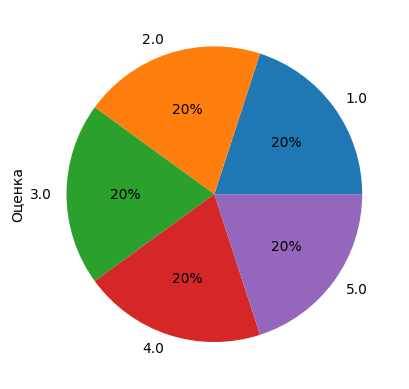

In [ ]:
n = 50
restaurants_all = []
dates_all = []
score_all = []
reviews_all = []
for i in range(n):
    site = 'https://www.restoran.ru/msk/opinions/?PAGEN_1=' + str(i + 1)
    response = requests.get(site)
    bs = BeautifulSoup(response.text, 'html.parser')
    restaurants = bs.find_all('div', class_='place-name-wrap')
    dates = bs.find_all('div', class_='review-date')
    reviews = bs.find_all('span', class_='review-text-preview')
    scores = bs.find_all('div', class_='place-rating')
    for restaurant in restaurants:
        restaurant = ''.join(char for char in str(restaurant.text) if char.isalpha())
        restaurants_all.append(restaurant)

    for date in dates:
        dates_all.append(date.text)

    for review in reviews:
        reviews_all.append(review.text)

    for score in scores:
      score_all.append(int(str(score.text)[0]))

with open("dataset.csv", mode="w", encoding='utf-8-sig') as w_file:
    file_writer = csv.writer(w_file, delimiter=',', lineterminator="\r")
    file_writer.writerow(["Ресторан", "Дата отзыва", "Отзыв", "Оценка"])
    for i in range(len(restaurants_all)):
        file_writer.writerow(
            [i, restaurants_all[i], dates_all[i], reviews_all[i], score_all[i]])

df = pd.read_csv('dataset.csv', index_col=0)

class_1 = df[df['Оценка'] == 1]
class_2 = df[df['Оценка'] == 2]
class_3 = df[df['Оценка'] == 3]
class_4 = df[df['Оценка'] == 4]
class_5 = df[df['Оценка'] == 5]

len_new = len(class_5)
undersampled_class_4_data = class_4.sample(n=len_new, replace=True, random_state=42)
undersampled_class_5_data = class_5.sample(n=len_new, replace=True, random_state=42)

oversampled_class_1_data = class_1.sample(n=len_new, replace=True, random_state=42)
oversampled_class_2_data = class_2.sample(n=len_new, replace=True, random_state=42)
oversampled_class_3_data = class_3.sample(n=len_new, replace=True, random_state=42)

new_df = pd.concat([oversampled_class_1_data, oversampled_class_2_data, oversampled_class_3_data,
                          undersampled_class_4_data, undersampled_class_5_data])

new_df['Оценка'].value_counts(ascending=False).plot(kind='pie', autopct='%1.0f%%')

In [ ]:
new_df.drop("Ресторан", axis= 1 , inplace= True )
new_df.drop("Дата отзыва", axis= 1 , inplace= True )

In [ ]:
new_df.tail(5)

,Отзыв,Оценка
830,Хороший клуб в котором можно провести время в ...,5.0
535,В ресторане доброделательная обс ановка встреч...,5.0
474,Нравится стриптиз. Бывал уже много раз в стрип...,5.0
158,Классное место! Атмосфера приятная и расслабле...,5.0
574,Определенно it's a match! Увидела этот рестора...,5.0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_df['Отзыв'], new_df['Оценка'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=10000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

itog = {}

In [ ]:
%%time
svc = svm.SVC()
svc.fit(X_train_tfidf, y_train)


y_pred = svc.predict(X_test_tfidf)
print(accuracy_score(y_test,y_pred))
itog['SVC'] = round(accuracy_score(y_test, y_pred), 2)

0.8625
CPU times: user 257 ms, sys: 0 ns, total: 257 ms
Wall time: 258 ms


In [ ]:
y_test = pd.Series(y_test, name='Actual').reset_index(drop=True)
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_test, y_pred)

print(df_confusion)

Predicted  1.0  2.0  3.0  4.0  5.0
Actual                            
1.0         46    0    0    0    0
2.0          0   47    0    9    0
3.0          0    0   42    2    0
4.0          0    0    0   40   10
5.0          0    1    0   11   32


In [ ]:
%%time
rf= RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)

y_pred = rf.predict(X_test_tfidf)
print(accuracy_score(y_test, y_pred))
itog['RandomForestClassifier'] = round(accuracy_score(y_test, y_pred), 2)

0.8541666666666666
CPU times: user 771 ms, sys: 9.57 ms, total: 780 ms
Wall time: 972 ms


In [ ]:
y_test = pd.Series(y_test, name='Actual').reset_index(drop=True)
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_test, y_pred)

print(df_confusion)

Predicted  1.0  2.0  3.0  4.0  5.0
Actual                            
1.0         46    0    0    0    0
2.0          0   50    0    3    3
3.0          0    0   42    2    0
4.0          0    1    2   34   13
5.0          0    1    1    9   33


In [ ]:
for key, value in itog.items():
  print(key, value)

SVC 0.86
RandomForestClassifier 0.85


In [ ]:
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        46
         2.0       0.96      0.89      0.93        56
         3.0       0.93      0.95      0.94        44
         4.0       0.71      0.68      0.69        50
         5.0       0.67      0.75      0.71        44

    accuracy                           0.85       240
   macro avg       0.86      0.86      0.85       240
weighted avg       0.86      0.85      0.86       240



Обучение с помщью RNN

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dropout, Bidirectional, BatchNormalization
from keras.regularizers import l2

In [ ]:
new_df['Отзыв'] = new_df['Отзыв'].fillna('')

le = LabelEncoder()
new_df['Оценка'] = le.fit_transform(new_df['Оценка'])

X_train, X_test, y_train, y_test = train_test_split(new_df['Отзыв'], new_df['Оценка'], test_size=0.2, random_state=42)

max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_pad = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min',
    restore_best_weights=True)

embedding_dim = 50

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_pad, y_train_one_hot, epochs=10, batch_size = 64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
12/12 [==============================] - 6s 185ms/step - loss: 1.6087 - accuracy: 0.1953 - val_loss: 1.5998 - val_accuracy: 0.3490
Epoch 2/10
12/12 [==============================] - 1s 95ms/step - loss: 1.5742 - accuracy: 0.3477 - val_loss: 1.5579 - val_accuracy: 0.3073
Epoch 3/10
12/12 [==============================] - 1s 95ms/step - loss: 1.4103 - accuracy: 0.4375 - val_loss: 1.2723 - val_accuracy: 0.4010
Epoch 4/10
12/12 [==============================] - 1s 132ms/step - loss: 1.0103 - accuracy: 0.5807 - val_loss: 0.9951 - val_accuracy: 0.5625
Epoch 5/10
12/12 [==============================] - 2s 124ms/step - loss: 0.9422 - accuracy: 0.6120 - val_loss: 1.0789 - val_accuracy: 0.5156
Epoch 6/10
12/12 [==============================] - 1s 80ms/step - loss: 0.8106 - accuracy: 0.6940 - val_loss: 0.9417 - val_accuracy: 0.6302
Epoch 7/10
12/12 [==============================] - 1s 56ms/step - loss: 0.6568 - accuracy: 0.7826 - val_loss: 0.9109 - val_accuracy: 0.6823
Epoch 8/10

Задание 2.

Примените один из трансформеров, например BERT к задаче классификации отзывов клиентов. Сравните полученные результаты с классическими методами машинного обучения, с RNN. Сделайте выводы.

Использование BERT

In [ ]:
import tensorflow_hub as hub
from transformers import BertTokenizer, TFBertModel
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, TFBertForSequenceClassification

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
class_1 = df[df['Оценка'] == 1]
class_2 = df[df['Оценка'] == 2]
class_3 = df[df['Оценка'] == 3]
class_4 = df[df['Оценка'] == 4]
class_5 = df[df['Оценка'] == 5]

len_new = len(class_2)
undersampled_class_4_data = class_4.sample(n=len_new, replace=True, random_state=42)
undersampled_class_5_data = class_5.sample(n=len_new, replace=True, random_state=42)

oversampled_class_1_data = class_1.sample(n=len_new, replace=True, random_state=42)
oversampled_class_2_data = class_2.sample(n=len_new, replace=True, random_state=42)
oversampled_class_3_data = class_3.sample(n=len_new, replace=True, random_state=42)

new_df = pd.concat([oversampled_class_1_data, oversampled_class_2_data, oversampled_class_3_data,
                          undersampled_class_4_data, undersampled_class_5_data])

new_df.drop("Ресторан", axis= 1 , inplace= True )
new_df.drop("Дата отзыва", axis= 1 , inplace= True )

X_train, X_test, y_train, y_test = train_test_split(new_df['Отзыв'], new_df['Оценка'], test_size=0.2, random_state=42)
max_sequence_length = 100

In [ ]:
X_train_tensor = tokenizer(X_train.tolist(), return_tensors="tf", padding=True, truncation=True, max_length=max_sequence_length)
X_test_tensor = tokenizer(X_test.tolist(), return_tensors="tf", padding=True, truncation=True, max_length=max_sequence_length)

In [ ]:
y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(y_test)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(X_train_tensor), y_train_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(X_test_tensor), y_test_tensor))

In [ ]:
num_samples = sum(1 for _ in train_dataset)

train_size = int(0.8 * num_samples)
val_size = num_samples - train_size

train_dataset = train_dataset.take(train_size)
val_dataset = train_dataset.skip(train_size)

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
X_train_np, y_train_np = next(iter(train_dataset.batch(num_samples)))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_np, y_train_np, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
10/10 [==============================] - 35s 832ms/step - loss: 3.8547 - accuracy: 0.2101 - val_loss: 1.6094 - val_accuracy: 0.1753
Epoch 2/4
10/10 [==============================] - 6s 589ms/step - loss: 1.6094 - accuracy: 0.2166 - val_loss: 1.6094 - val_accuracy: 0.2143
Epoch 3/4
10/10 [==============================] - 6s 599ms/step - loss: 1.6094 - accuracy: 0.1938 - val_loss: 1.6094 - val_accuracy: 0.2143
Epoch 4/4
10/10 [==============================] - 6s 596ms/step - loss: 1.6469 - accuracy: 0.2150 - val_loss: 1.6094 - val_accuracy: 0.1753


Датасет в целях запуска был урезан в 5 раз, т.к. иначе при запуске кода происходила ошибка, связанная с недостаточным объемом памяти CUDA, а также объемом RAM предоставленной видеокарты. В связи с малым объемом данных



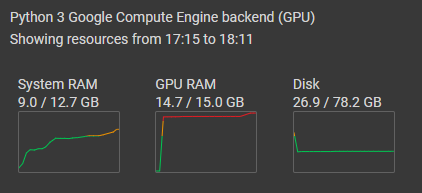

Тем не менее, даже так можно сделать вывод, что точность и эффективность моделей с использованием такого трансформера, как BERT, соответствует вычислительной мощности, требуемой для запуска модели с ним.

Задание 3.

Примените один из трансформеров, например BERT, к задаче генерации англоязычного и русскоязычного текстов. Сравните результаты с LSTM. Сделайте выводы.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

In [ ]:
import requests
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer
import random

def load_text_from_url(url):
    response = requests.get(url)
    return response.text

def generate_text(input_text, model, tokenizer):
    input_ids = tokenizer.encode(input_text, return_tensors='tf')
    attention_mask = tf.ones_like(input_ids)

    generated_text = model.generate(input_ids, attention_mask=attention_mask, max_length=100, num_beams=5, no_repeat_ngram_size=2)

    generated_text_decoded = tokenizer.decode(generated_text[0], skip_special_tokens=True)
    return generated_text_decoded

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = TFGPT2LMHeadModel.from_pretrained('gpt2')

txt_url = 'https://s3.amazonaws.com/text-datasets/nietzsche.txt'
input_text = load_text_from_url(txt_url)

sentences = input_text.split('.')

random_index = random.randint(0, len(sentences) - 1)
random_sentence = sentences[random_index]

generated_text = generate_text(random_sentence, model, tokenizer)

print(f"Исходное предложение: {random_sentence}")
print(f"Сгенерированный текст: {generated_text}")

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Исходное предложение:  To
reduce anyone to silence by physical manifestations of savagery or by a
terrorizing process is a relic of under civilization
Сгенерированный текст:  To
reduce anyone to silence by physical manifestations of savagery or by a
terrorizing process is a relic of under civilization. It is not a new phenomenon, but it is
the result of a centuries-long process of socialization.
It is the product of centuries of cultural and economic development, and it has been the result
of a long period of political, economic, social, cultural, political and cultural development. In the

history of the world, there has


Задание 4.

Примените один из трансформеров, например BERT, к задаче машинного перевода.

In [ ]:
!apt-get install -y python3-sentencepiece

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libsentencepiece0
The following NEW packages will be installed:
  libsentencepiece0 python3-sentencepiece
0 upgraded, 2 newly installed, 0 to remove and 24 not upgraded.
Need to get 878 kB of archives.
After this operation, 2,774 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libsentencepiece0 amd64 0.1.96-1build1 [832 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 python3-sentencepiece amd64 0.1.96-1build1 [45.5 kB]
Fetched 878 kB in 0s (2,353 kB/s)
Selecting previously unselected package libsentencepiece0.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../libsentencepiece0_0.1.96-1build1_amd64.deb ...
Unpacking libsentencepiece0 (0.1.96-1build1) ...
Selecting previously unselected package python3-sentencepiece.
Prepar

In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.0 MB/s eta 0:00:00


In [ ]:
from transformers import MarianMTModel, MarianTokenizer
import sentencepiece as spm
import random

In [ ]:
def load_text_from_url(url):
    response = requests.get(url)
    return response.text

def get_random_index(text):
    sentences = text.split('.')
    return random.randint(0, len(sentences) - 3)

src_lang = "en"
tgt_lang = "fr"

model_name = f'Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)


txt_url = 'https://s3.amazonaws.com/text-datasets/nietzsche.txt'
input_text = load_text_from_url(txt_url)
random_index = get_random_index(input_text)

selected_sentences = input_text.split('.')[random_index:random_index + 3]

translations = []
for sentence in selected_sentences:
  input_ids = tokenizer.encode(sentence, return_tensors="pt")

  with torch.no_grad():
        outputs = model.generate(input_ids)
        translated_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)
        translations.append(translated_sentence)

print(f"Случайные предложения: {'. '.join(selected_sentences)}")
print(f"Переводы: {'. '.join(translations)}")

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Случайные предложения: --We may, if we please, become sensible, even in our
waking moments, of a condition that is as a door and vestibule to
dreaming.  If we close our eyes the brain immediately conjures up a
medley of impressions of light and color, apparently a sort of imitation
and echo of the impressions forced in upon the brain during its waking
moments.  And now the mind, in co-operation with the imagination,
transforms this formless play of light and color into definite figures,
moving groups, landscapes
Переводы: --Nous pouvons, s'il vous plaît, devenir raisonnables, même dans nos moments de réveil, d'une condition qui est comme une porte et vestibule à rêver. Si nous fermons les yeux, le cerveau évoque immédiatement un mélange d'impressions de lumière et de couleur, apparemment une sorte d'imitation et d'écho des impressions forcées sur le cerveau pendant ses moments de réveil.. Et maintenant, l'esprit, en coopération avec l'imagination, transforme ce jeu sans forme de lumièr